# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [144]:
# loading the data:

customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [25]:
# What does each column mean?
# https://archive.ics.uci.edu/ml/datasets/wholesale+customers

customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [26]:
# Any categorical data to convert?

# check data types
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [27]:
# Any missing data to remove?

customers.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

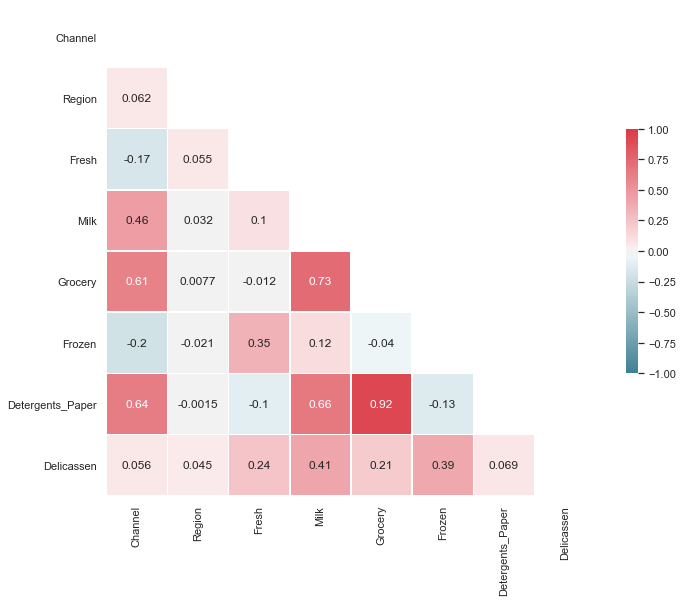

In [28]:
# Column collinearity - any high correlations?
# Yes
# Grocery shows high correlation with detergents_paper, milk, and channel
# Channel also shows collinearity with milk and and detergents_paper
# milk and detergents_paper show collinearity

corr = customers.corr()

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# annot=True, 
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
             square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [29]:
# Descriptive statistics - any outliers to remove?

customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [35]:
customers[(customers['Frozen'] >= customers['Frozen'].quantile(q=0.95))]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
39,1,3,56159,555,902,10002,212,2916
70,1,3,16705,2037,3202,10643,116,1365
93,1,3,11314,3090,2062,35009,71,2698
103,1,3,56082,3504,8906,18028,1480,2498
125,1,3,76237,3473,7102,16538,778,918
181,1,3,112151,29627,18148,16745,4948,8550
183,1,3,36847,43950,20170,36534,239,47943
196,1,1,30624,7209,4897,18711,763,2876
240,1,1,22096,3575,7041,11422,343,2564
265,1,1,5909,23527,13699,10155,830,3636


In [31]:
customers.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [32]:
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

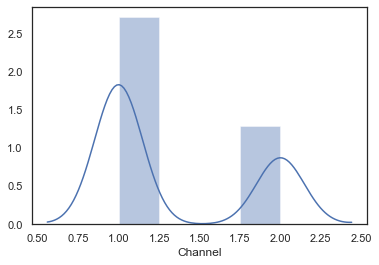

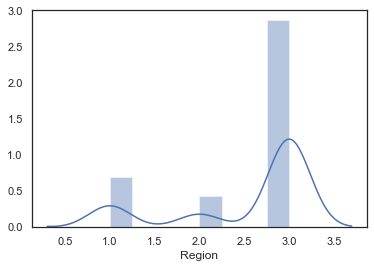

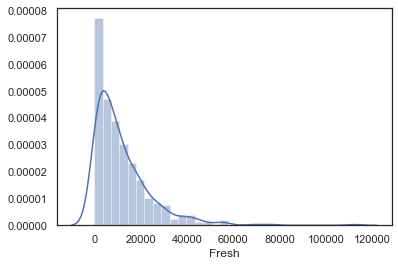

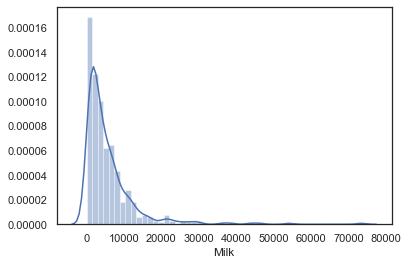

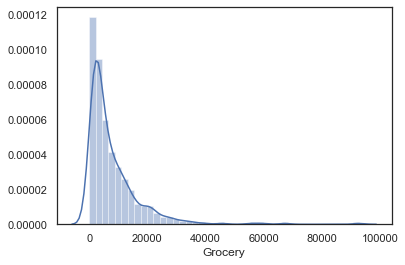

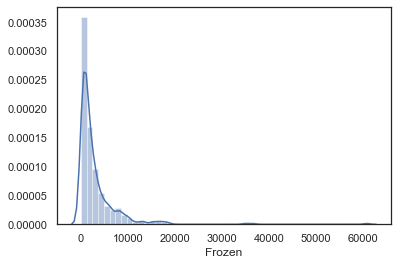

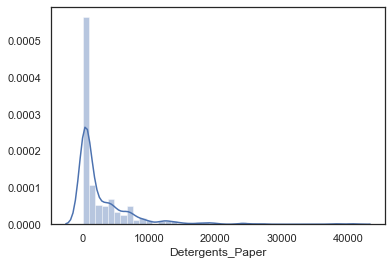

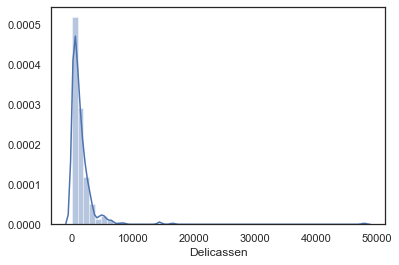

In [34]:
# plot a histogram for each column in the dataframe

for i, col in enumerate(customers.columns):
    plt.figure(i)
    sns.distplot(customers[col], kde=True)
    plt.show()

In [ ]:
# Your observations here

# What does each column mean?
# Channel - categorical - Horeca (Hotel/Restaurant/Café) or Retail channel 
# Region - categorical - Lisbon, Oporto or Other
# All other columns represent continuoues variables, annual spending per type of product

# Any categorical data to convert?
# Yes
# Region and Channel have integers but these are codes for categorical variables
# Converted to dummies

# Any missing data to remove?
# No

# Column collinearity - any high correlations?
# Yes
# Grocery shows high correlation with detergents_paper, milk, and channel
# Channel also shows collinearity with milk and and detergents_paper
# milk and detergents_paper show collinearity

# Descriptive statistics - any outliers to remove?
# There seem to be outliers in Fresh, Milk, Grocery, Frozen, Detergents_Paper and Delicatessen

# Column-wise data distribution - is the distribution skewed?
# will not consider channel and region: these are categorical and will be one hot encoded
# distributions are right skewed (positively skewed): many small values, few high values

# Pareto principle?
# I don't know
# It may be so: we see a few customers with high values in terms of annual spending per type of product, and many
# customers with small values

# Anything else?


# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [145]:
# Your code here

# convert two columns into string data types
columns_to_convert = ['Channel', 'Region']
customers[columns_to_convert] = customers[columns_to_convert].astype(str)

# get dummies for categorical variables
customers = pd.get_dummies(customers)

# check
customers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,12669,9656,7561,214,2674,1338,0,1,0,0,1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1
3,13265,1196,4221,6404,507,1788,1,0,0,0,1
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1


In [146]:
# drop outliers
# Fresh, Milk, Frozen, Detergents_Paper and Delicassen
# For loop

columns = ['Fresh', 'Milk', 'Frozen', 'Detergents_Paper', 'Delicassen']

for column in columns:
     customers.drop(customers[customers[column] == customers[column].max()].index, axis=0, inplace=True)


In [133]:
# drop columns based on collinearity
# drop Grocery

#customers.drop('Grocery', axis=1, inplace=True)

In [147]:
customers.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,12669,9656,7561,214,2674,1338,0,1,0,0,1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1
3,13265,1196,4221,6404,507,1788,1,0,0,0,1
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1


# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [148]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:

scaler = StandardScaler()

scaler.fit(customers)

customers_scale = scaler.transform(customers)

customers_scale

array([[ 0.08918974,  0.71687054, -0.00882555, ..., -0.46377128,
        -0.34387778,  0.62787799],
       [-0.39290064,  0.74268862,  0.22688384, ..., -0.46377128,
        -0.34387778,  0.62787799],
       [-0.4533767 ,  0.57470343,  0.00562002, ..., -0.46377128,
        -0.34387778,  0.62787799],
       ...,
       [ 0.24914204,  1.69460469,  2.65503118, ..., -0.46377128,
        -0.34387778,  0.62787799],
       [-0.11517466, -0.56984236, -0.63468273, ..., -0.46377128,
        -0.34387778,  0.62787799],
       [-0.75970854, -0.61728728, -0.6020334 , ..., -0.46377128,
        -0.34387778,  0.62787799]])

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [149]:
# Your code here:

from sklearn.cluster import KMeans

# initialize and fit model
# I'll pass 4 clusters as parameter
kmeans = KMeans(n_clusters=4, random_state=0).fit(customers_scale)

customers['labels'] = kmeans.labels_

In [150]:
customers.head()


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3,labels
0,12669,9656,7561,214,2674,1338,0,1,0,0,1,2
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1,2
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1,2
3,13265,1196,4221,6404,507,1788,1,0,0,0,1,0
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1,2


Count the values in `labels`.

In [151]:
# Your code here:
customers['labels'].value_counts()

0    236
2    117
3     63
1     19
Name: labels, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [152]:
# Your code here
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

from sklearn.cluster import DBSCAN

# initialize and fit model
dbscan = DBSCAN(eps=0.5).fit(customers_scale)

customers['labels_DBSCAN'] = dbscan.labels_

In [153]:
customers.head()


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3,labels,labels_DBSCAN
0,12669,9656,7561,214,2674,1338,0,1,0,0,1,2,-1
1,7057,9810,9568,1762,3293,1776,0,1,0,0,1,2,-1
2,6353,8808,7684,2405,3516,7844,0,1,0,0,1,2,-1
3,13265,1196,4221,6404,507,1788,1,0,0,0,1,0,-1
4,22615,5410,7198,3915,1777,5185,0,1,0,0,1,2,-1


Count the values in `labels_DBSCAN`.

In [154]:
# Your code here

customers['labels_DBSCAN'].value_counts()


-1    319
 0     98
 2     13
 1      5
Name: labels_DBSCAN, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

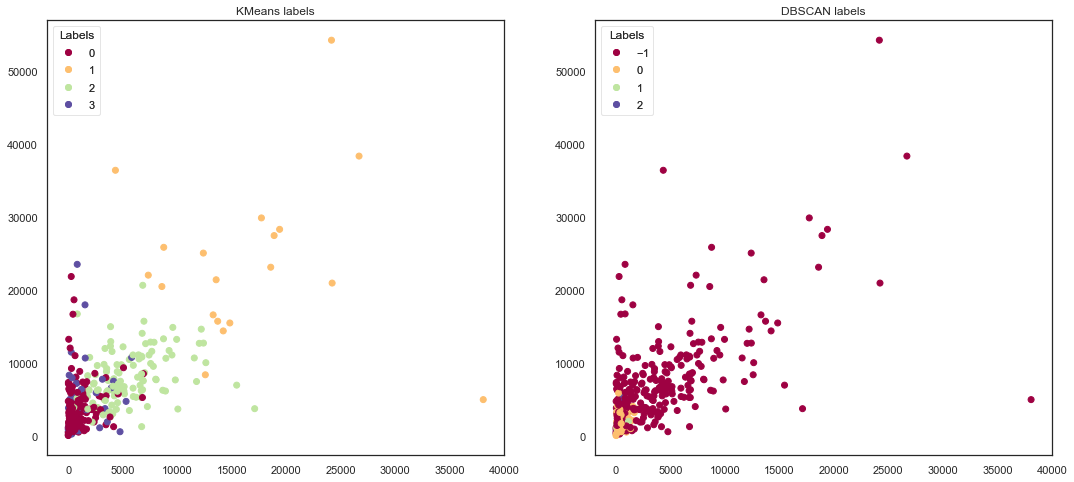

In [155]:
X = customers['Detergents_Paper']
y = customers['Milk']

f, (a1, a2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Scatter plot for KMeans labels
scatter_a1 = a1.scatter(X,y, c=customers['labels'], cmap="Spectral")

# Produce a legend for the labels (colors)
# fancybox and framealpha make legend transparent so we won't miss points
legend1 = a1.legend(*scatter_a1.legend_elements(), loc="upper left", title="Labels", fancybox=True, framealpha=0.3)
a1.add_artist(legend1)

a1.set_title('KMeans labels')


# Scatter plot for DBSCAN labels
scatter_a2 = a2.scatter(X,y, c=customers['labels_DBSCAN'], cmap="Spectral")

# Produce a legend for the labels (colors)
# fancybox and framealpha make legend transparent so we won't miss points
legend2 = a2.legend(*scatter_a2.legend_elements(), loc="upper left", title="Labels", fancybox=True, framealpha=0.3)
a2.add_artist(legend2)

a2.set_title('DBSCAN labels')


plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

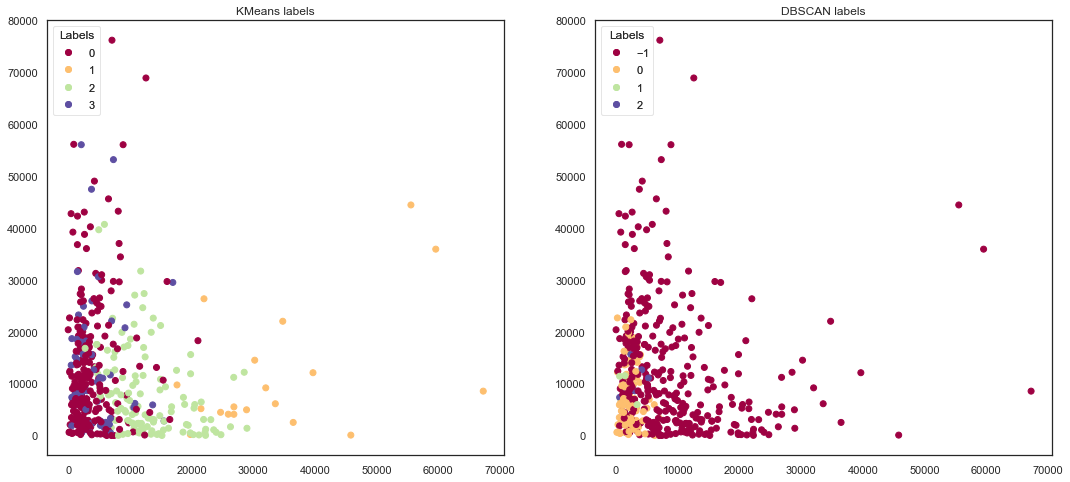

In [156]:
# Your code here:

X = customers['Grocery']
y = customers['Fresh']

f, (a1, a2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Scatter plot for KMeans labels
scatter_a1 = a1.scatter(X,y, c=customers['labels'], cmap="Spectral")

# Produce a legend for the labels (colors)
# fancybox and framealpha make legend transparent so we won't miss points
legend1 = a1.legend(*scatter_a1.legend_elements(), loc="upper left", title="Labels", fancybox=True, framealpha=0.3)
a1.add_artist(legend1)

a1.set_title('KMeans labels')


# Scatter plot for DBSCAN labels
scatter_a2 = a2.scatter(X,y, c=customers['labels_DBSCAN'], cmap="Spectral")

# Produce a legend for the labels (colors)
# fancybox and framealpha make legend transparent so we won't miss points
legend2 = a2.legend(*scatter_a2.legend_elements(), loc="upper left", title="Labels", fancybox=True, framealpha=0.3)
a2.add_artist(legend2)

a2.set_title('DBSCAN labels')


plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

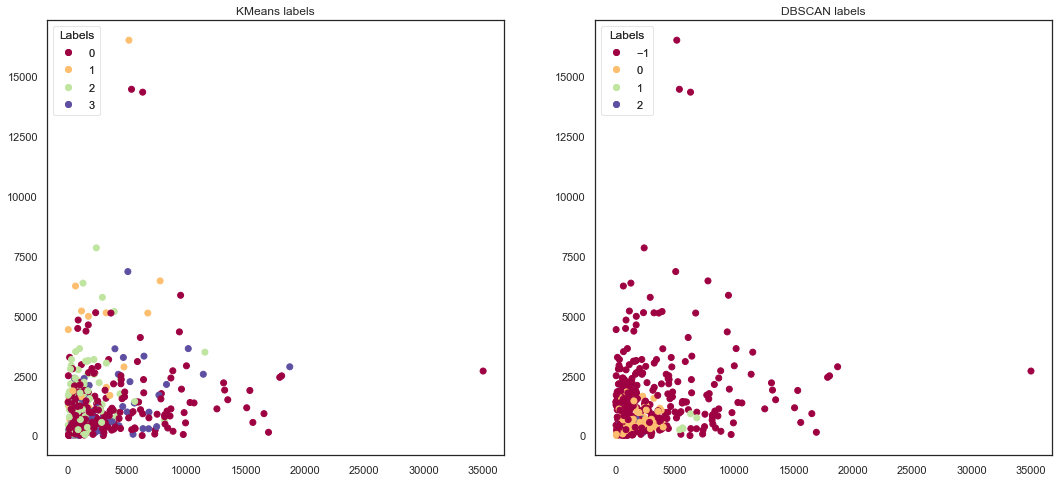

In [157]:
# Your code here:

X = customers['Frozen']
y = customers['Delicassen']

f, (a1, a2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Scatter plot for KMeans labels
scatter_a1 = a1.scatter(X,y, c=customers['labels'], cmap="Spectral")

# Produce a legend for the labels (colors)
# fancybox and framealpha make legend transparent so we won't miss points
legend1 = a1.legend(*scatter_a1.legend_elements(), loc="upper left", title="Labels", fancybox=True, framealpha=0.3)
a1.add_artist(legend1)

a1.set_title('KMeans labels')


# Scatter plot for DBSCAN labels
scatter_a2 = a2.scatter(X,y, c=customers['labels_DBSCAN'], cmap="Spectral")

# Produce a legend for the labels (colors)
# fancybox and framealpha make legend transparent so we won't miss points
legend2 = a2.legend(*scatter_a2.legend_elements(), loc="upper left", title="Labels", fancybox=True, framealpha=0.3)
a2.add_artist(legend2)

a2.set_title('DBSCAN labels')


plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [158]:
# Your code here:

customers_kmeans = customers.groupby(by='labels').mean()

customers_dbscans = customers.groupby(by='labels_DBSCAN').mean()

In [159]:
customers_kmeans.mean()

Fresh               11390.383489
Milk                 9640.690678
Grocery             13778.295241
Frozen               2645.405954
Detergents_Paper     5933.413682
Delicassen           1896.168407
Channel_1               0.484127
Channel_2               0.515873
Region_1                0.323999
Region_2                0.091242
Region_3                0.584759
labels_DBSCAN          -0.730831
dtype: float64

In [160]:
customers_dbscans.mean()

Fresh               9546.888286
Milk                3164.315247
Grocery             3924.720555
Frozen              2995.037256
Detergents_Paper    1197.214669
Delicassen           822.515885
Channel_1              0.890282
Channel_2              0.109718
Region_1               0.300157
Region_2               0.036050
Region_3               0.663793
labels                 1.065831
dtype: float64

Which algorithm appears to perform better?

In [ ]:
# Your observations here

# Evaluation of algorithm is based on distance between means.
# The wider the distance the better: Centroids


# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [ ]:
# Your code here

In [ ]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here